In [2]:
import torch
from PIL import Image
import torchvision.transforms as T
import torchvision.ops as ops
from models import build_model
from models.matcher import build_matcher
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import util.misc as utils
from torch.utils.data import DataLoader

from datasets.torchvision_datasets.open_world import OWDetection
from datasets.coco import make_coco_transforms
from util import box_ops

from args import Args

{'OWDETR': ('aeroplane', 'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'cow', 'dog', 'horse', 'motorbike', 'sheep', 'train', 'elephant', 'bear', 'zebra', 'giraffe', 'truck', 'person', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'chair', 'diningtable', 'pottedplant', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'bed', 'toilet', 'sofa', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'tvmonitor', 'bottle', 'unknown'), 'TOWOD': ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def apply_nms(boxes, scores, labels, iou_threshold=0.5):
    """
    NMS 적용 함수
    
    Args:
        boxes: 바운딩 박스 좌표 [N, 4]
        scores: 각 박스의 confidence score [N]
        labels: 각 박스의 클래스 레이블 [N]
        iou_threshold: NMS에서 사용할 IoU threshold
    """
    # 클래스별로 NMS 적용
    unique_labels = torch.unique(labels)
    keep_boxes = []
    keep_scores = []
    keep_labels = []
    
    for label in unique_labels:
        # 현재 클래스의 박스들만 선택
        class_mask = labels == label
        class_boxes = boxes[class_mask]
        class_scores = scores[class_mask]
        
        # NMS 적용
        keep_idx = ops.nms(class_boxes, class_scores, iou_threshold)
        
        # 결과 저장
        keep_boxes.append(boxes[class_mask][keep_idx])
        keep_scores.append(scores[class_mask][keep_idx])
        keep_labels.append(labels[class_mask][keep_idx])
    
    # 모든 클래스의 결과 합치기
    if keep_boxes:
        keep_boxes = torch.cat(keep_boxes)
        keep_scores = torch.cat(keep_scores)
        keep_labels = torch.cat(keep_labels)
        return keep_boxes, keep_scores, keep_labels
    else:
        return boxes, scores, labels

def visualize_detection(image, outputs, class_names, known_score_threshold=0.3, unknown_score_threshold=0.6, unknown_label_id=80, iou_threshold=0.5):
    """
    Detection 결과 시각화 함수 (NMS 포함)
    """
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    
    # 이미지 표시
    ax.imshow(image)
    
    # 색상 맵 설정
    colors = plt.cm.rainbow(np.linspace(0, 1, unknown_label_id))
    
    # 첫 번째 이미지의 결과 가져오기
    result = outputs[0]
    
    # 각 detection에 대해
    scores = result['scores'].cpu()
    labels = result['labels'].cpu()
    boxes = result['boxes'].cpu()
    
    # score threshold 적용
    known_keep = (labels < unknown_label_id) & (scores > known_score_threshold)
    unknown_keep = (labels == unknown_label_id) & (scores > unknown_score_threshold)
    keep = known_keep | unknown_keep
    scores = scores[keep]
    labels = labels[keep]
    boxes = boxes[keep]
    
    # NMS 적용
    # boxes, scores, labels = apply_nms(boxes, scores, labels, iou_threshold)
    
    for score, label, box in zip(scores, labels, boxes):
        cls_id = label.item()
        
        # 박스 좌표
        xmin = float(box[0])
        ymin = float(box[1])
        xmax = float(box[2])
        ymax = float(box[3])
        
        # 박스 그리기
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin, 
            linewidth=2, 
            edgecolor=colors[cls_id] if cls_id < unknown_label_id else 'red',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # 클래스 레이블과 confidence score 표시
        class_name = class_names[cls_id]
        ax.text(
            xmin, ymin - 5,
            f'{class_name} {score:.2f}',
            color=colors[cls_id] if cls_id < unknown_label_id else 'red',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
            fontsize=8
        )
    
    plt.axis('off')
    plt.show()

def run_inference(model, postprocessors, image_path, device='cuda'):
    """
    이미지에 대한 전체 추론 과정을 수행
    """
    # 이미지 로드
    image = Image.open(image_path).convert('RGB')
    w, h = image.size
    
    # 이미지 전처리
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)
    print(f"Image shape: {img_tensor.shape}")

    # 원본 이미지 크기
    target_sizes = torch.tensor([[h, w]], device=device)
    
    # 모델 추론
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        results = postprocessors['bbox'](outputs, target_sizes)
    
    return image, results

In [5]:
args = Args()

In [6]:
# 모델과 postprocessor 준비
model, criterion, postprocessors, _, contextual_labeling = build_model(args, mode=args.model_type)
model.to(device)

Invalid class range: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
DINO resnet50


/home/yongho/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yongho/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


running with exemplar_replay_selection
Initialized Contextual Labeling Module


DeformableDETR(
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affin

In [7]:
class_names = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'unknown']

In [8]:
# 체크포인트 로드 (옵션) / Load checkpoint (optional)
checkpoint = torch.load("./test_model/my1/t1.pth", map_location=device)
model.load_state_dict(checkpoint['model'], strict=False)

<All keys matched successfully>

In [26]:
args.objectness_thr = 0.6

Image shape: torch.Size([1, 3, 800, 1066])


/home/yongho/Desktop/Contextual_Labeling/models/position_encoding.py:49: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/home/yongho/Desktop/Contextual_Labeling/models/prob_deformable_detr.py:537: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_boxes = topk_indexes 

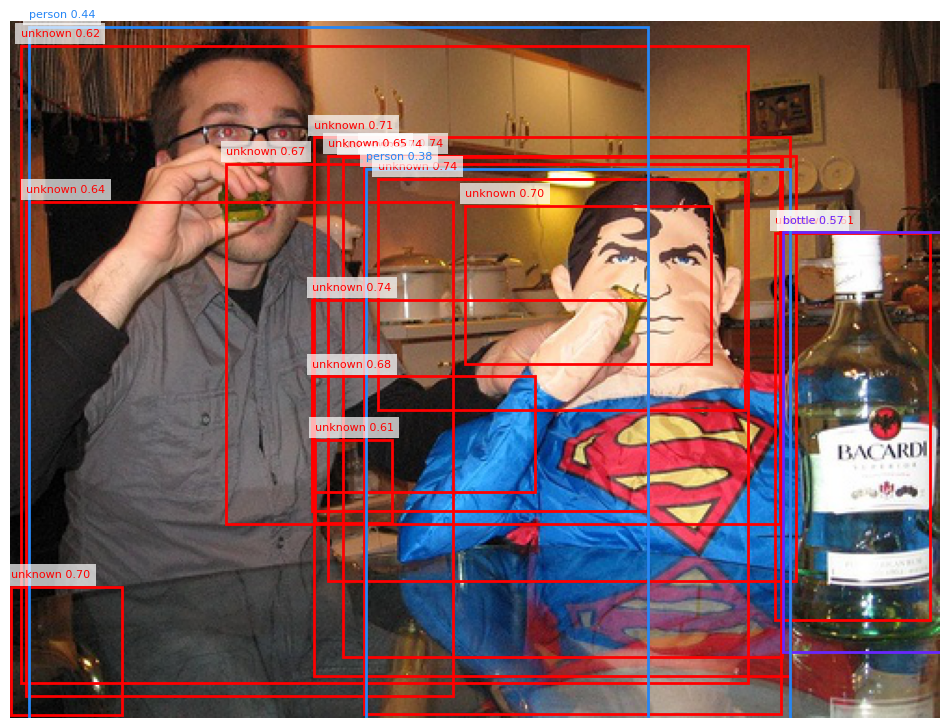

In [27]:
# 이미지 경로
image_path = './data/OWOD/JPEGImages/000202.jpg'#'./test_img/000002.jpg'
# 추론 및 시각화 (NMS 포함)
image, results = run_inference(model, postprocessors, image_path)
visualize_detection(image, results, class_names,
                   known_score_threshold=0.2,  # confidence threshold
                   unknown_score_threshold=args.objectness_thr, # confidence threshold for unknown class
                   iou_threshold=0.2,    # NMS IoU threshold
                   unknown_label_id=80)  # unknown class ID

In [10]:
def get_datasets(args):
    print(args.dataset)

    train_set = args.train_set
    test_set = args.test_set
    dataset_train = OWDetection(args, args.data_root, image_set=args.train_set, transforms=make_coco_transforms(args.train_set), dataset = args.dataset)
    dataset_val = OWDetection(args, args.data_root, image_set=args.test_set, dataset = args.dataset, transforms=make_coco_transforms(args.test_set))

    print(args.train_set)
    print(args.test_set)
    print(dataset_train)
    print(dataset_val)

    return dataset_train, dataset_val

In [11]:
dataset_train, dataset_val = get_datasets(args)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, args.batch_size, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                pin_memory=True)

TOWOD
owod_t1_train
owod_all_task_test
Dataset OWDetection
    Number of datapoints: 16551
    Root location: ./data/OWOD
    [['train'], Compose(
    Compose(
)
)]
Dataset OWDetection
    Number of datapoints: 10246
    Root location: ./data/OWOD
    [['test'], Compose(
    Compose(
)
)]


In [12]:
for samples, targets in data_loader_val:
    samples = samples.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    outputs = model(samples)
    orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
    results = postprocessors['bbox'](outputs, orig_target_sizes)
    break
    # visualize_detection(samples, results, 
    #                score_threshold=0.3,  # confidence threshold
    #                iou_threshold=0.2,    # NMS IoU threshold
    #                unknown_label_id=80)  # unknown class ID

In [13]:
orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)

In [14]:
outputs = model(samples)

In [15]:
pp = postprocessors['bbox']
out_logits, pred_obj, out_bbox = outputs['pred_logits'], outputs['pred_obj'], outputs['pred_boxes']

In [16]:
out_logits[:,:, pp.invalid_cls_logits] = -10e10

In [17]:
obj_prob = torch.exp(-pp.temperature * pred_obj).unsqueeze(-1)
prob = obj_prob * out_logits.sigmoid()

In [18]:
topk_values, topk_indexes = torch.topk(prob.view(out_logits.shape[0], -1), pp.pred_per_im, dim=1)

In [19]:
scores = topk_values

In [20]:
topk_boxes = topk_indexes // out_logits.shape[2]

/tmp/ipykernel_198172/2578720982.py:1: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_boxes = topk_indexes // out_logits.shape[2]


In [21]:
labels = topk_indexes % out_logits.shape[2]

## Contextual Labeling

In [22]:
results = contextual_labeling(outputs, targets)

Contextual: [(tensor([ 0, 16]), tensor([0, 1]))]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
results[0]['matched']

{'boxes': tensor([[0.2697, 0.7339, 0.5567, 0.4370],
         [0.5274, 0.5145, 0.9338, 0.9828]], device='cuda:0'),
 'labels': tensor([11, 14], device='cuda:0'),
 'scores': tensor([0.2124, 0.4294], device='cuda:0')}

In [ ]:
results[0]['unmatched']

{'boxes': tensor([[0.9565, 0.3276, 0.0830, 0.2134],
         [0.0450, 0.3217, 0.0881, 0.4912],
         [0.6004, 0.5093, 0.7657, 0.9997],
         [0.5782, 0.3920, 0.8085, 0.7099],
         [0.9827, 0.5128, 0.0351, 0.9998],
         [0.6834, 0.4129, 0.5509, 0.8468],
         [0.5099, 0.9160, 1.0000, 0.1983],
         [0.9864, 0.8067, 0.0237, 0.2091],
         [0.4850, 0.7152, 0.9901, 0.5455],
         [0.4483, 0.7232, 0.8771, 0.5044],
         [0.7673, 0.6716, 0.5529, 0.5385],
         [0.9878, 0.9528, 0.0287, 0.1172],
         [0.3027, 0.7302, 0.6542, 0.4449],
         [0.9266, 0.8985, 0.1089, 0.1344],
         [0.4313, 0.0245, 0.9725, 0.0997],
         [0.5351, 0.4966, 0.8852, 0.9989],
         [0.1734, 0.7282, 0.4009, 0.3197],
         [0.1693, 0.9708, 0.6118, 0.0809],
         [0.9926, 0.3713, 0.0166, 0.2110],
         [0.5620, 0.4946, 0.8287, 0.9997],
         [0.5102, 0.5831, 0.9699, 0.7727],
         [0.0244, 0.9522, 0.0507, 0.1220],
         [0.0845, 0.4569, 0.1691, 0.9687],
  